In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.stats.api as sms
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
df = pd.read_csv('test_basic.csv')
df.head()

,user_id,conversion,test
0,860955,0,0
1,911569,0,1
2,673989,0,0
3,562761,0,0
4,64288,0,0


In [3]:
agg_df = df.groupby('test')['conversion'].agg(['count', 'sum']).reset_index()
agg_df.columns
agg_df.columns = ['variant', 'volume', 'conversions']
agg_df

,variant,volume,conversions
0,0,37431,1636
1,1,41512,2308


In [4]:
agg_df.iloc[0,2]

1636

In [6]:
# assume CLT holds
p_0 = agg_df.iloc[0,2]/agg_df.iloc[0,1]
p_1 = agg_df.iloc[1,2]/agg_df.iloc[1,1]
print("CVR_for variant 0 is:", p_0)
print("CVR_for variant 1 is:", p_1)

CVR_for variant 0 is: 0.04370708770804948
CVR_for variant 1 is: 0.05559838119098092


In [7]:
p_hat= (agg_df.iloc[0,2]+agg_df.iloc[1,2])/(agg_df.iloc[0,1]+agg_df.iloc[1,1])
p_hat

0.04996009779207783

In [8]:
var_p_hat = p_hat*(1-p_hat) 
var_p_hat

0.04746408642068385

In [26]:
# z = (p_0-p_1)/(var*(1/n_1)+1/n_2)
z = (p_0-p_1)/np.sqrt(var_p_hat*(1/agg_df.iloc[0,1]+1/agg_df.iloc[1,1]))
z

-7.657592742200931

In [10]:
import statsmodels.stats.api as sms

In [11]:
import scipy as stats

In [29]:
p_value = 2*(1-stats.norm.cdf(abs(z))) # two-sided test
p_value 

1.887379141862766e-14

In [30]:
df.loc[df['test']==0]['conversion']

0        0
2        0
3        0
4        0
5        0
        ..
78938    0
78939    0
78940    0
78941    0
78942    0
Name: conversion, Length: 37431, dtype: int64

In [33]:
test = stats.ttest_ind(df.loc[df['test']==0]['conversion'], df.loc[df['test']==1]['conversion'], equal_var=False )

In [34]:
test

TtestResult(statistic=-7.705449851546837, pvalue=1.3189559402908635e-14, df=78932.19917546153)

In [37]:
test.statistic

-7.705449851546837

In [38]:
test.pvalue

1.3189559402908635e-14

In [42]:
# sample size
p1_and_p2 = sms.proportion_effectsize(0.1, 0.11)
p1_and_p2

-0.03262940076737697

In [51]:
sms.NormalIndPower().solve_power(p1_and_p2, power=0.8, alpha = 0.05)
# solve for any one parameter of the power of a two sample z-test

# for z-test the keywords are:
# effect_size, nobs1, alpha, power, ratio

# exactly one needs to be None, all others need numeric values

680.3526619127882

In [47]:
possible_p2 = np.arange(0.105, 0.155, 0.005)
print(possible_p2)

[0.105 0.11  0.115 0.12  0.125 0.13  0.135 0.14  0.145 0.15 ]


In [48]:
sample_size = []
for i in possible_p2:
    p1_and_p2 = sms.proportion_effectsize(0.1, i)
    ss = sms.NormalIndPower().solve_power(p1_and_p2,power=0.8, alpha = 0.05)
    sample_size.append(ss)

In [49]:
sample_size

[57755.63900543422,
 14744.104836925611,
 6686.150491784501,
 3834.5957398840183,
 2500.4771063548874,
 1768.0950485742067,
 1321.8940896247254,
 1029.3252690344636,
 826.7173018829511,
 680.3526619127882]

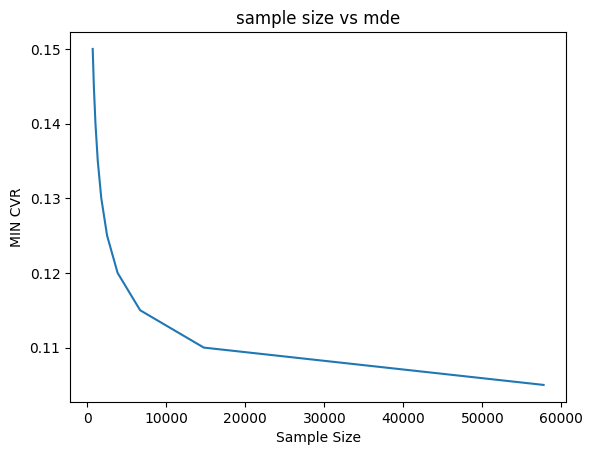

In [50]:
plt.plot(sample_size, possible_p2)
plt.title('sample size vs mde')
plt.xlabel('Sample Size')
plt.ylabel('MIN CVR')
plt.show()

In [53]:
rand = pd.read_csv('randomization.csv')
rand.head()

,user_id,source,device,browser_language,browser,sex,age,country,test,conversion
0,1,SEO,Web,EN,Chrome,M,38,Chile,0,0
1,2,SEO,Mobile,ES,Android_App,M,27,Colombia,0,0
2,3,SEO,Mobile,ES,Iphone_App,M,18,Guatemala,1,0
3,5,Ads,Web,ES,Chrome,M,22,Argentina,1,0
4,8,Ads,Mobile,ES,Android_App,M,19,Venezuela,1,0


In [63]:
rand.columns

Index(['user_id', 'source', 'device', 'browser_language', 'browser', 'sex',
       'age', 'country', 'test', 'conversion'],
      dtype='object')

In [86]:
rand.groupby('test')['test'].agg(['count']).reset_index()

,test,count
0,0,185311
1,1,215774


# Checking that randomization worked well simply means making sure that all variables have the same distribution in test and control. So, taking for instance the first variable, source, it would mean checking that proportion of users coming from ads, SEO, and direct is the same.

In [58]:
freq_table = pd.crosstab(rand['test'], rand['source'])
freq_table

source,Ads,Direct,SEO
test,,,
0,74352,37238,73721
1,86448,43047,86279


In [62]:
chi2, p_value, _,_ = stats.chi2_contingency(freq_table)
print(f" P_value:{p_value}")

 P_value:0.3387045847778523


In [64]:
cols = ['source', 'device', 'browser_language', 'browser', 'sex', 'country']

In [65]:
for col in cols: 
    df = pd.crosstab(rand['test'], rand[col])
    chi2, p_value, _,_ = stats.chi2_contingency(freq_table)
    print(f"P_value of {col}:{p_value}")

P_value of source:0.3387045847778523
P_value of device:0.3387045847778523
P_value of browser_language:0.3387045847778523
P_value of browser:0.3387045847778523
P_value of sex:0.3387045847778523
P_value of country:0.3387045847778523


In [76]:
pd.crosstab(rand['test'], rand['country'])

country,Argentina,Bolivia,Chile,Colombia,Costa Rica,Ecuador,El Salvador,Guatemala,Honduras,Mexico,Nicaragua,Panama,Paraguay,Peru,Uruguay,Venezuela
test,,,,,,,,,,,,,,,,
0,9356,5550,9853,27088,2660,8036,4108,7622,4361,64209,3419,1966,3650,16869,415,16149
1,37377,5574,9884,26972,2649,7859,4067,7503,4207,64275,3304,1985,3697,16797,3719,15905


In [73]:
agg_df = rand.groupby('country')['test'].agg([("freq_test_0", lambda x:len(x[x==0])), ("freq_test_1", lambda x:len(x[x==1]))])
agg_df

,freq_test_0,freq_test_1
country,,
Argentina,9356,37377
Bolivia,5550,5574
Chile,9853,9884
Colombia,27088,26972
Costa Rica,2660,2649
Ecuador,8036,7859
El Salvador,4108,4067
Guatemala,7622,7503
Honduras,4361,4207


In [75]:
print(agg_df/agg_df.sum())

             freq_test_0  freq_test_1
country                              
Argentina       0.050488     0.173223
Bolivia         0.029950     0.025833
Chile           0.053170     0.045807
Colombia        0.146176     0.125001
Costa Rica      0.014354     0.012277
Ecuador         0.043365     0.036422
El Salvador     0.022168     0.018848
Guatemala       0.041131     0.034772
Honduras        0.023533     0.019497
Mexico          0.346493     0.297881
Nicaragua       0.018450     0.015312
Panama          0.010609     0.009199
Paraguay        0.019697     0.017134
Peru            0.091031     0.077845
Uruguay         0.002239     0.017236
Venezuela       0.087145     0.073711


In [81]:
drop_df = rand.drop(['user_id'], axis = 1)
drop_df.head()

,source,device,browser_language,browser,sex,age,country,test,conversion
0,SEO,Web,EN,Chrome,M,38,Chile,0,0
1,SEO,Mobile,ES,Android_App,M,27,Colombia,0,0
2,SEO,Mobile,ES,Iphone_App,M,18,Guatemala,1,0
3,Ads,Web,ES,Chrome,M,22,Argentina,1,0
4,Ads,Mobile,ES,Android_App,M,19,Venezuela,1,0


In [83]:
dummy_df = pd.get_dummies(drop_df)
dummy_df.shape

(401085, 36)

In [87]:
train_cols = dummy_df.drop(columns = ['test','conversion'])

In [89]:
tree=DecisionTreeClassifier(
    #change weights. Our data set is now perfectly balanced. It makes easier to look at tree output
    class_weight="balanced",
    #only split if if it's worthwhile. The default value of 0 means always split no matter what if you can increase overall performance, which creates tons of noisy and irrelevant splits
    min_impurity_decrease = 0.001
    )
tree.fit(train_cols,dummy_df['test'])
  

DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.001)

[Text(0.6, 0.8333333333333334, 'country_Argentina <= 0.5\nsamples = 100.0%\nvalue = [0.5, 0.5]'),
 Text(0.4, 0.5, 'country_Uruguay <= 0.5\nsamples = 88.3%\nvalue = [0.535, 0.465]'),
 Text(0.5, 0.6666666666666667, 'True  '),
 Text(0.2, 0.16666666666666666, 'samples = 87.3%\nvalue = [0.539, 0.461]'),
 Text(0.6, 0.16666666666666666, 'samples = 1.0%\nvalue = [0.115, 0.885]'),
 Text(0.8, 0.5, 'samples = 11.7%\nvalue = [0.226, 0.774]'),
 Text(0.7, 0.6666666666666667, '  False')]

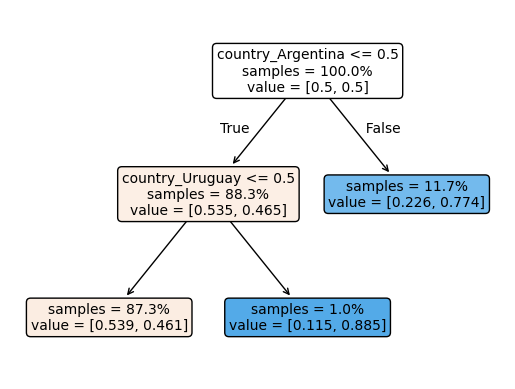

In [95]:
# fig = plt.figure(figsize=(50,30))
plot_tree(tree, feature_names=train_cols.columns, filled=True,
    rounded=True,
    fontsize=10,  # Increase font size
    proportion=True,  # Ensures nodes are proportionate to the number of samples
    impurity=False  # Hides impurity values for a cleaner look
)


In [97]:
dummy_df.columns

Index(['age', 'test', 'conversion', 'source_Ads', 'source_Direct',
       'source_SEO', 'device_Mobile', 'device_Web', 'browser_language_EN',
       'browser_language_ES', 'browser_language_Other', 'browser_Android_App',
       'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Iphone_App',
       'browser_Opera', 'browser_Safari', 'sex_F', 'sex_M',
       'country_Argentina', 'country_Bolivia', 'country_Chile',
       'country_Colombia', 'country_Costa Rica', 'country_Ecuador',
       'country_El Salvador', 'country_Guatemala', 'country_Honduras',
       'country_Mexico', 'country_Nicaragua', 'country_Panama',
       'country_Paraguay', 'country_Peru', 'country_Uruguay',
       'country_Venezuela'],
      dtype='object')

In [99]:
dummy_df.groupby('test')[['country_Uruguay','country_Argentina']].mean().reset_index()

,test,country_Uruguay,country_Argentina
0,0,0.002239,0.050488
1,1,0.017236,0.173223


In [100]:
rand.head()

,user_id,source,device,browser_language,browser,sex,age,country,test,conversion
0,1,SEO,Web,EN,Chrome,M,38,Chile,0,0
1,2,SEO,Mobile,ES,Android_App,M,27,Colombia,0,0
2,3,SEO,Mobile,ES,Iphone_App,M,18,Guatemala,1,0
3,5,Ads,Web,ES,Chrome,M,22,Argentina,1,0
4,8,Ads,Mobile,ES,Android_App,M,19,Venezuela,1,0


In [350]:
t_test = stats.ttest_ind(rand.query('test==0')['conversion'],rand.query('test==1')['conversion'], equal_var= False)

In [351]:
t_test.confidence_interval(confidence_level=0.95)

ConfidenceInterval(low=0.0035798370383018055, high=0.006181420719843084)

In [104]:
clean_df = rand.loc[~rand['country'].isin(['Uruguay','Argentina'])]
clean_df

,user_id,source,device,browser_language,browser,sex,age,country,test,conversion
0,1,SEO,Web,EN,Chrome,M,38,Chile,0,0
1,2,SEO,Mobile,ES,Android_App,M,27,Colombia,0,0
2,3,SEO,Mobile,ES,Iphone_App,M,18,Guatemala,1,0
4,8,Ads,Mobile,ES,Android_App,M,19,Venezuela,1,0
5,11,Ads,Web,ES,Chrome,F,28,Colombia,1,0
...,...,...,...,...,...,...,...,...,...,...
401079,999989,SEO,Mobile,ES,Android_App,M,18,Guatemala,0,1
401080,999993,Ads,Web,ES,Chrome,M,30,Venezuela,0,0
401081,999996,Direct,Mobile,EN,Iphone_App,M,28,Costa Rica,0,0
401083,999999,Ads,Mobile,EN,Android_App,M,23,Venezuela,1,0


In [105]:
rand.shape

(401085, 10)

In [106]:
stats.ttest_ind(clean_df.query('test==0')['conversion'],clean_df.query('test==1')['conversion'], equal_var= False)

TtestResult(statistic=-0.3583455794481447, pvalue=0.7200849282884503, df=350196.74523927376)

In [107]:
# exerise

In [109]:
sub_df = rand.loc[rand['country'].isin(['Uruguay','Argentina'])]

In [114]:
country_counts = sub_df.groupby(['test', 'country']).size().reset_index(name = 'tot_users')
country_counts 

,test,country,tot_users
0,0,Argentina,9356
1,0,Uruguay,415
2,1,Argentina,37377
3,1,Uruguay,3719


In [124]:
sub_df.groupby('test')['country'].agg([('Argentina', lambda x :len(x[x=='Argentina'])),\
('Uruguay', lambda x: len(x[x=='Uruguay']))])

,Argentina,Uruguay
test,,
0,9356,415
1,37377,3719


In [126]:
country_counts = rand.groupby(['test', 'country']).size().unstack(fill_value=0)
total_users = rand.shape[0]
total_users

401085

In [128]:
country_counts.columns

Index(['Argentina', 'Bolivia', 'Chile', 'Colombia', 'Costa Rica', 'Ecuador',
       'El Salvador', 'Guatemala', 'Honduras', 'Mexico', 'Nicaragua', 'Panama',
       'Paraguay', 'Peru', 'Uruguay', 'Venezuela'],
      dtype='object', name='country')

In [130]:
country_counts['Argentina']

test
0     9356
1    37377
Name: Argentina, dtype: int64

In [134]:
country_counts.loc[0].sum()

185311

In [135]:
country_counts.loc[1].sum()

215774

In [131]:
(len(country_counts.loc[0,'Argentina']) + x)/(x+country_counts.loc[0].sum()) = 

9356

# Novelty Effect

In [12]:
df = pd.read_csv('novelty_effect.csv')
df.head()

,user_id,signup_date,test_date,browser,test,pages_visited
0,34,2015-01-01,2015-08-15,Chrome,0,6
1,59,2015-01-01,2015-08-12,Chrome,1,6
2,178,2015-01-01,2015-08-10,Safari,1,3
3,383,2015-01-01,2015-08-05,Firefox,1,9
4,397,2015-01-01,2015-08-27,IE,0,1


In [13]:
df.groupby('test')['user_id'].agg({'count','nunique'})

,count,nunique
test,,
0,48737,48737
1,49136,49136


In [31]:
# method 1
result = stats.ttest_ind(df.query('test==0')['pages_visited'], df.query('test==1')['pages_visited'],equal_var = False)

In [34]:
result.confidence_interval(confidence_level=0.95)

ConfidenceInterval(low=-0.11568527137057465, high=-0.05468628299534502)

In [15]:
# method 2
agg_df = df.groupby(['test'])['pages_visited'].mean().reset_index(name ='avg_page_visited')
agg_df

,test,avg_page_visited
0,0,4.609804
1,1,4.694989


In [17]:
s_1 = np.std(df.query('test==1')['pages_visited'],ddof =1)
s_1

2.124610027820732

In [18]:
s_0 = np.std(df.query('test==0')['pages_visited'],ddof =1)
s_0

2.706319950642741

In [19]:
n_1 = df.query('test==1').shape[0]
n_1

49136

In [20]:
n_0 = df.query('test==0').shape[0]
n_0

48737

In [21]:
t = (agg_df.iloc[0][1]-agg_df.iloc[1][1])/np.sqrt(s_1**2/n_1+s_0**2/n_0)
t

/var/folders/zq/hqq8b43s3fj4rb11sgc943bw0000gn/T/ipykernel_80219/627517656.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t = (agg_df.iloc[0][1]-agg_df.iloc[1][1])/np.sqrt(s_1**2/n_1+s_0**2/n_0)


-5.474295518566027

In [23]:
import scipy.stats as stats

In [28]:
2*(1-stats.norm.cdf(abs(t)))

4.392555164045575e-08

In [142]:
# for old users
ab_test_old = stats.ttest_ind(df.query('test==0 and test_date != signup_date')['pages_visited'], df.query('test==1 and test_date != signup_date')['pages_visited'],equal_var = False)

In [141]:
# for new users
stats.ttest_ind(df.query('test==0 and test_date == signup_date')['pages_visited'], df.query('test==1 and test_date == signup_date')['pages_visited'],equal_var = False)

TtestResult(statistic=1.0809363577979878, pvalue=0.27973874896130424, df=19563.34110900016)

In [30]:
stats.norm.ppf(1-0.05/2)

1.959963984540054

In [144]:
if (ab_test_old.pvalue>0.05/2):
  print ("Returning users: Non-significant results")
elif (ab_test_old.statistic>0):
  print ("Returning users: Statistically better results")
else:
  print ("Returning users: Statistically worse results")

Returning users: Statistically worse results


In [145]:
# right tail or left tail?

# A/B Testing: User Referral Program

In [147]:
df = pd.read_csv('referral.csv')
df.head()

,user_id,date,country,money_spent,is_referral,device_id
0,2,2015-10-03,FR,65,0,EVDCJTZMVMJDG
1,3,2015-10-03,CA,54,0,WUBZFTVKXGQQX
2,6,2015-10-03,FR,35,0,CBAPCJRTFNUJG
3,7,2015-10-03,UK,73,0,PRGXJZAJKMXRH
4,7,2015-10-03,MX,35,0,PRGXJZAJKMXRH


In [150]:
df['user_id'].nunique()

18809

In [151]:
df.shape

(97341, 6)

In [152]:
df.groupby(['is_referral'])['user_id'].agg({'count','nunique'})

,nunique,count
is_referral,,
0,11951,69324
1,12715,28017


In [156]:
df.query('is_referral==0').date.max()

'2015-11-27'

In [157]:
df.groupby(['user_id'])['is_referral'].agg({'count','nunique'})

,nunique,count
user_id,,
1,1,9
2,1,14
3,1,15
4,1,13
5,1,6
...,...,...
19996,2,2
19997,2,2
19998,1,2


In [159]:
df.groupby(['is_referral'])['money_spent'].sum().reset_index()

,is_referral,money_spent
0,0,3034612
1,1,1315787


In [160]:
df.columns

Index(['user_id', 'date', 'country', 'money_spent', 'is_referral',
       'device_id'],
      dtype='object')

In [181]:
df['date'] = pd.to_datetime(df['date'])

In [182]:
df_by_user = df.groupby(['date','user_id'])['money_spent'].sum().reset_index()
df_by_user.head()

,date,user_id,money_spent
0,2015-10-03,2,65
1,2015-10-03,3,54
2,2015-10-03,6,35
3,2015-10-03,7,108
4,2015-10-03,10,36


In [163]:
df_by_user.shape

(86000, 3)

,date,is_referral,money_spent
0,2015-10-03,0,128475
1,2015-10-04,0,130772
2,2015-10-05,0,46946
3,2015-10-06,0,49711
4,2015-10-07,0,45242


In [176]:
df.sort_values(by = ['user_id', 'date'],inplace = True)

In [178]:
#fix is_referral putting the first value
df['is_referral'] = df.groupby('user_id')['is_referral'].transform('first')
print(df.groupby('user_id').is_referral.nunique().max())

1


In [186]:
df_by_referral = df.groupby(['date','is_referral'])['money_spent'].sum().reset_index()
df_by_referral.head()

,date,is_referral,money_spent
0,2015-10-03,0,128475
1,2015-10-04,0,130772
2,2015-10-05,0,46946
3,2015-10-06,0,49711
4,2015-10-07,0,45242


/var/folders/zq/hqq8b43s3fj4rb11sgc943bw0000gn/T/ipykernel_14340/276932208.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


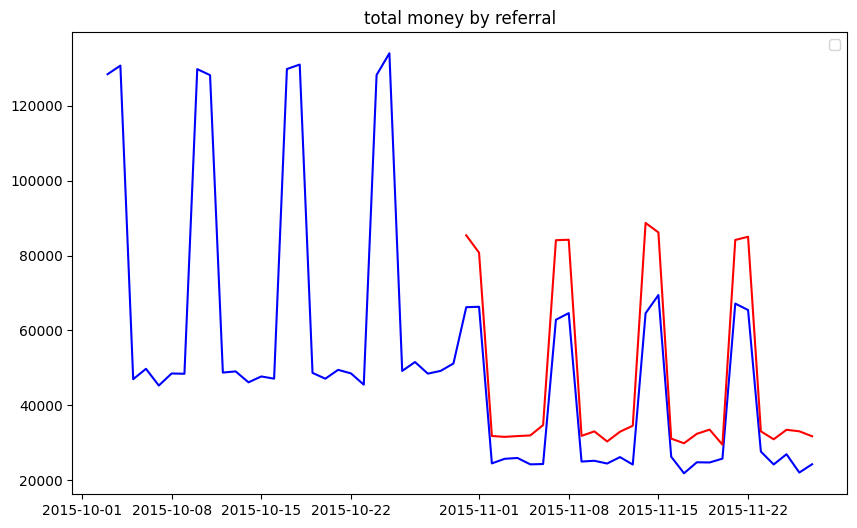

In [187]:
plt.figure(figsize=(10, 6))
plt.plot(df_by_referral.query('is_referral==0')['date'], df_by_referral.query('is_referral==0')['money_spent'], color = 'blue')
plt.plot(df_by_referral.query('is_referral==1')['date'], df_by_referral.query('is_referral==1')['money_spent'], color = 'red')
plt.title('total money by referral')
plt.legend()
plt.show()

In [198]:
df_by_referral = df.groupby(['date','is_referral']).agg({'money_spent':'sum','user_id':'nunique' }).reset_index()
df_by_referral.columns = ['date','is_referral','money_spent','user_cnts']
df_by_referral.head()

,date,is_referral,money_spent,user_cnts
0,2015-10-03,0,128475,2283
1,2015-10-04,0,130772,2274
2,2015-10-05,0,46946,1030
3,2015-10-06,0,49711,1020
4,2015-10-07,0,45242,966


/var/folders/zq/hqq8b43s3fj4rb11sgc943bw0000gn/T/ipykernel_14340/3507984852.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


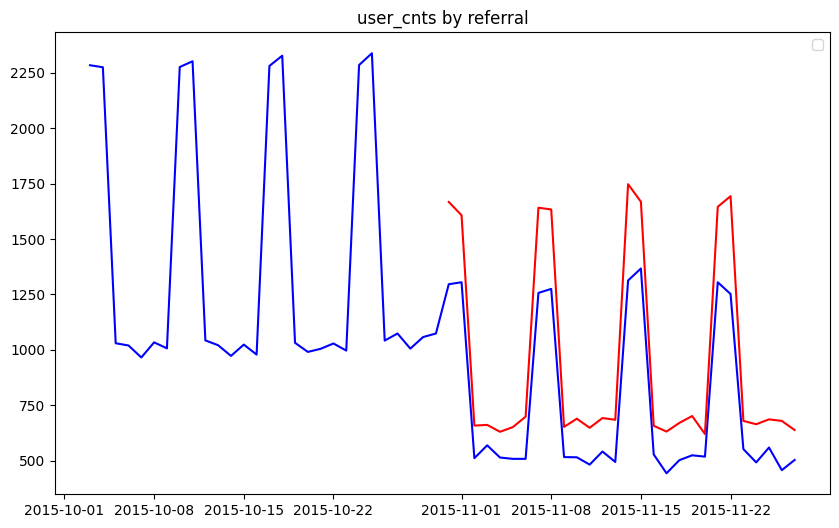

In [199]:
plt.figure(figsize=(10, 6))
plt.plot(df_by_referral.query('is_referral==0')['date'], df_by_referral.query('is_referral==0')['user_cnts'], color = 'blue')
plt.plot(df_by_referral.query('is_referral==1')['date'], df_by_referral.query('is_referral==1')['user_cnts'], color = 'red')
plt.title('user_cnts by referral')
plt.legend()
plt.show()
# The number of users not going through the referral program dropped. 
# This is a huge sign of cannibalization. The new feature is taking away existing customers from another source. 
# Other common examples of cannibalization are when marketing campaigns, such as paid ads, 
# take away users from free channels such as SEO.

/var/folders/zq/hqq8b43s3fj4rb11sgc943bw0000gn/T/ipykernel_14340/1642026520.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


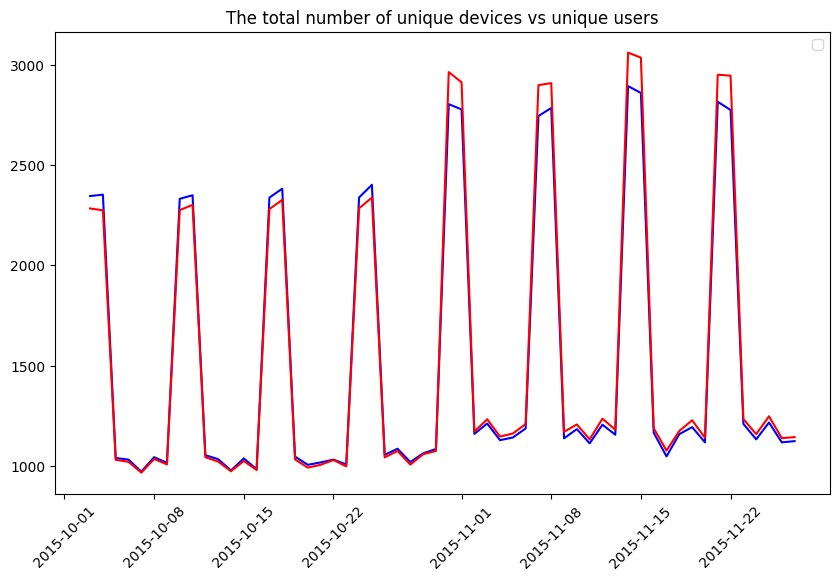

In [204]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=45)
plt.plot(df.groupby('date')['device_id'].nunique(), color='blue')
plt.plot(df.groupby('date')['user_id'].nunique(), color='red')
plt.title('The total number of unique devices vs unique users')
plt.legend()
plt.show()
# Before the test, we had more unique devices than users, which makes sense. 
# The same user could be using different devices. 
# After the test, we have more users than devices!
# Meaning different users are sharing the same device! There is definitely some fraud going on.


In [205]:
import fbprophet
  
#prepare the before the change dataset. We use total transaction value as main metric
data_prediction = data.query('date<\'2015-10-31\'').groupby('date')['money_spent'].sum().reset_index()
#change column names and index
data_prediction['ds'] = data_prediction['date']
data_prediction.rename({'money_spent': 'y'}, axis=1, inplace=True)
data_prediction.set_index('date', inplace=True)
  
#Let's build the model using prophet. From previous plots, time series appear pretty straightforward and flattish. Default values should do fine
ts = fbprophet.Prophet(interval_width=0.95)
ts.fit(data_prediction)

ModuleNotFoundError: No module named 'fbprophet'

# A/B TESTING: Pricing Test

In [4]:
test_df = pd.read_csv('Pricing_Test/test_results.csv')
test_df

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0
...,...,...,...,...,...,...,...,...
316795,17427,2015-04-11 09:29:15,ads_facebook,web,windows,0,39,0
316796,687787,2015-03-16 23:31:55,direct_traffic,web,windows,0,39,0
316797,618863,2015-04-11 01:35:19,ads-google,web,mac,0,39,0
316798,154636,2015-05-14 05:46:42,friend_referral,mobile,android,0,39,0


In [213]:
test_df['user_id'].nunique()

316800

In [207]:
user_df = pd.read_csv('Pricing_Test/user_table.csv')
user_df.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [210]:
test_df.columns

Index(['user_id', 'timestamp', 'source', 'device', 'operative_system', 'test',
       'price', 'converted'],
      dtype='object')

In [212]:
test_df[['test','price']].drop_duplicates()

,test,price
0,0,39
3,1,59
1457,1,39
8238,0,59


In [221]:
clean_df = test_df.loc[((test_df['test']==1)& (test_df['price']==59))|((test_df['test']==0)& (test_df['price']==39))]
clean_df

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0
...,...,...,...,...,...,...,...,...
316795,17427,2015-04-11 09:29:15,ads_facebook,web,windows,0,39,0
316796,687787,2015-03-16 23:31:55,direct_traffic,web,windows,0,39,0
316797,618863,2015-04-11 01:35:19,ads-google,web,mac,0,39,0
316798,154636,2015-05-14 05:46:42,friend_referral,mobile,android,0,39,0


In [225]:
clean_df['revenue'] = clean_df['price']*clean_df['converted']

/var/folders/zq/hqq8b43s3fj4rb11sgc943bw0000gn/T/ipykernel_14340/2523125033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['revenue'] = clean_df['price']*clean_df['converted']


In [222]:
stats.ttest_ind(clean_df.query('test==0')['converted'],clean_df.query('test==1')['converted'],equal_var=False)

TtestResult(statistic=9.044608417898376, pvalue=1.5119397664466364e-19, df=260426.2855934621)

In [226]:
stats.ttest_ind(clean_df.query('test==0')['revenue'],clean_df.query('test==1')['revenue'],equal_var=False)

TtestResult(statistic=-5.715224666463108, pvalue=1.0972577312420781e-08, df=186141.738219264)

In [228]:
clean_df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,0


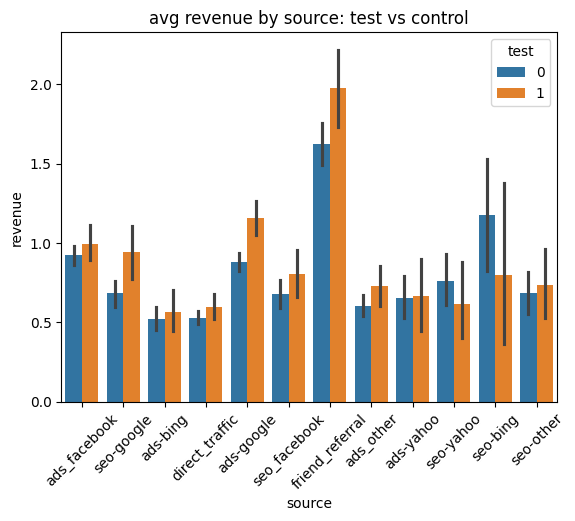

In [235]:
sns.barplot(x='source', y='revenue', hue = 'test', data = clean_df)
plt.title('avg revenue by source: test vs control')
plt.xticks(rotation=45)
plt.show()
# the vertical bars (|) at the top of each bar represent error bars, which typically indicate the variability or uncertainty of the revenue values shown. 
# These error bars could represent standard deviation, standard error, or confidence intervals, depending on how the data was processed.
# These error bars help assess whether differences between test and control groups are statistically significant.
# If the error bars overlap considerably,
# it suggests that the difference in revenue might not be statistically significant.

In [236]:
# clean_df.groupby(['test','source'])['revenue'].agg({'count', 'sum','mean'}).reset_index()

In [344]:
sample = clean_df.groupby(['test','source'])['revenue'].sum().reset_index()
wide = sample.pivot(columns = 'test',index = 'source', values = 'revenue').reset_index()
wide 

test,source,0,1
0,ads-bing,7605,4661
1,ads-google,33306,24898
2,ads-yahoo,3159,1829
3,ads_facebook,31434,19175
4,ads_other,11583,7729
5,direct_traffic,20397,12862
6,friend_referral,21333,14927
7,seo-bing,1560,649
8,seo-google,10296,7611
9,seo-other,4017,2478


In [349]:
pd.melt(wide,id_vars = 'source', value_name = 'revenue')

,source,test,revenue
0,ads-bing,0,7605
1,ads-google,0,33306
2,ads-yahoo,0,3159
3,ads_facebook,0,31434
4,ads_other,0,11583
5,direct_traffic,0,20397
6,friend_referral,0,21333
7,seo-bing,0,1560
8,seo-google,0,10296
9,seo-other,0,4017


In [224]:
# agg_df = clean_df.groupby('test')['converted'].agg({'count', 'sum','mean'}).reset_index()
# agg_df

,test,sum,mean,count
0,0,4030,0.019900,202517
1,1,1772,0.015555,113918


([0, 1], [Text(0, 0, 'mobile'), Text(1, 0, 'web')])

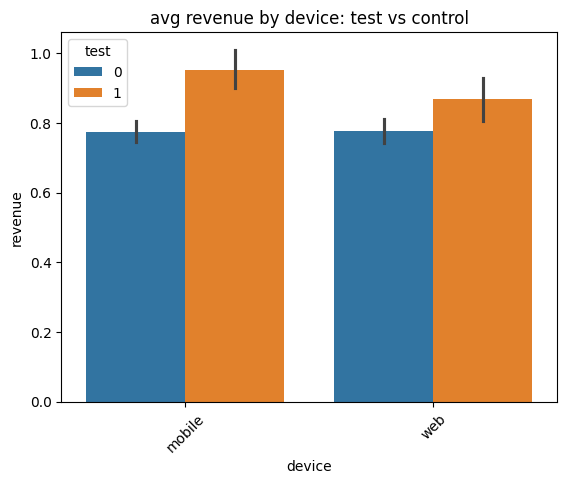

In [239]:
sns.barplot(x='device', y='revenue', hue='test', data=clean_df)
plt.title('avg revenue by device: test vs control')
plt.xticks(rotation=45)
# It appears that mobile users are less price sensitive. 
# This is typically very good as mobile is in most cases the channel that’s proportionally growing more between the two. 
# So, in the long run, the revenue gain from the price change could be even larger.

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'iOS'),
  Text(1, 0, 'android'),
  Text(2, 0, 'mac'),
  Text(3, 0, 'windows'),
  Text(4, 0, 'other'),
  Text(5, 0, 'linux')])

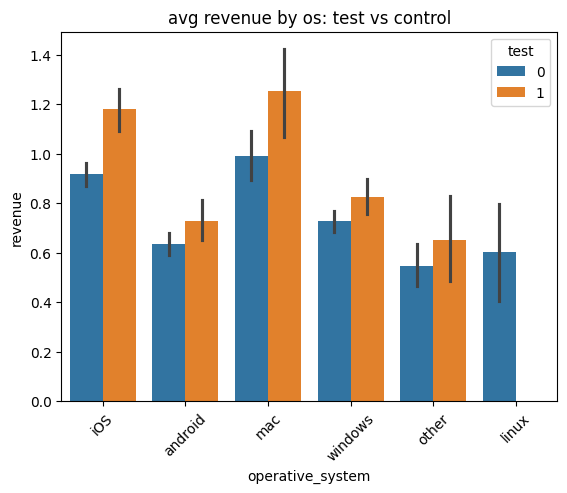

In [240]:
sns.barplot(x='operative_system', y='revenue', hue='test', data=clean_df)
plt.title('avg revenue by os: test vs control')
plt.xticks(rotation=45)
# Not surprisingly, we can see that mac/iOS react better to the price increase. 
# Most likely, they are acting as a proxy for different user characteristics. 
# It would probably be a good idea to figure out how to get more of those users and target them more via,
# for instance, ads or ad-hoc marketing campaigns.

In [242]:
clean_df_v2 = clean_df.query('operative_system != "linux"')
clean_df_v2

,user_id,timestamp,source,device,operative_system,test,price,converted,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,0
...,...,...,...,...,...,...,...,...,...
316795,17427,2015-04-11 09:29:15,ads_facebook,web,windows,0,39,0,0
316796,687787,2015-03-16 23:31:55,direct_traffic,web,windows,0,39,0,0
316797,618863,2015-04-11 01:35:19,ads-google,web,mac,0,39,0,0
316798,154636,2015-05-14 05:46:42,friend_referral,mobile,android,0,39,0,0


In [243]:
stats.ttest_ind(clean_df_v2.query('test==0')['revenue'],clean_df_v2.query('test==1')['revenue'],equal_var=False)

TtestResult(statistic=-6.184240028400434, pvalue=6.253458285742887e-10, df=181667.22654265029)

In [246]:
#join the two datasets on user_id
data=pd.merge(left=clean_df_v2, right=user_df, how='left', on='user_id')
data.shape

(312305, 13)

In [251]:
top_city = data['city'].value_counts().reset_index().sort_values(by='count', ascending=False).head(10)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'New York'),
  Text(1, 0, 'Chicago'),
  Text(2, 0, 'Las Vegas'),
  Text(3, 0, 'Jacksonville'),
  Text(4, 0, 'Los Angeles'),
  Text(5, 0, 'San Antonio'),
  Text(6, 0, 'Philadelphia'),
  Text(7, 0, 'Houston'),
  Text(8, 0, 'Indianapolis'),
  Text(9, 0, 'San Jose')])

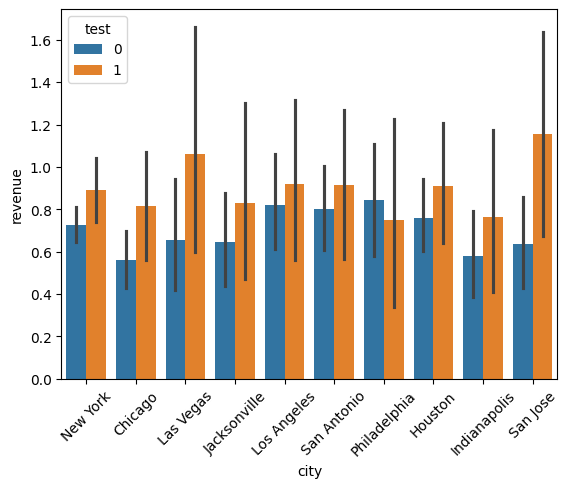

In [257]:
sns.barplot(x='city', y = 'revenue', hue = 'test',data = data[data['city'].isin(top_city['city'])])
plt.xticks(rotation = 45)

In [260]:
data.groupby('test')['converted'].mean()

test
0    0.019949
1    0.015823
Name: converted, dtype: float64

In [261]:
0.015823/0.019949-1

-0.20682740989523285

# [Bonus] After how many days you would have stopped the test?


In [264]:
conversion_rate_control = clean_df_v2.query('test == 0')['converted'].mean()
conversion_rate_control

0.019948780159051084

In [265]:
p1_and_p2 = sms.proportion_effectsize(conversion_rate_control, conversion_rate_control*39/59)


In [266]:
sample_size = sms.NormalIndPower().solve_power(p1_and_p2, power=0.8,alpha=0.05)
## It solves for one parameter in a power analysis equation, given the other inputs. 

In [267]:
sample_size

5534.884691425768

In [270]:
round(sample_size)

5535

In [271]:
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,revenue,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,0,Fishers,USA,39.95,-86.02


In [279]:
pd.to_datetime(data.timestamp.str.split(' ').str[0]).dt.strftime('%W')

0         18
1         18
2         13
3         18
4         20
          ..
312300    14
312301    11
312302    14
312303    19
312304    09
Name: timestamp, Length: 312305, dtype: object

In [280]:
data['week_of_year'] = pd.to_datetime(data.timestamp.str.split(' ').str[0]).dt.strftime('%W')

In [283]:
users_week = data['week_of_year'].value_counts().sort_index()
users_week 

week_of_year
09    24376
10    23928
11    24130
12    24164
13    23705
14    24519
15    23862
16    23922
17    24039
18    24162
19    23951
20    23721
21    23826
Name: count, dtype: int64

In [284]:
users_week.index

Index(['09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
       '21'],
      dtype='object', name='week_of_year')

In [288]:
users_week.drop(['09','21']).mean() # The drop() method works with index labels directly, so you don't need to reference users_week.index.

24009.363636363636

In [290]:
# allocation_pct*weekly_traffic*2 = sample size
sample_size/(users_week.drop(['09','21']).mean() *2)

0.11526512687414277

# practice linear regression

In [306]:
clean_df_v2.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,revenue,week
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,0,18
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,0,18
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,0,13
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,0,18
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,0,20


In [294]:
import statsmodels.api as sm

In [305]:
clean_df_v2['week'] = pd.to_datetime(clean_df_v2['timestamp'].str.split(' ').str[0]).dt.strftime('%W')

/var/folders/zq/hqq8b43s3fj4rb11sgc943bw0000gn/T/ipykernel_14340/2884043670.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_v2['week'] = pd.to_datetime(clean_df_v2['timestamp'].str.split(' ').str[0]).dt.strftime('%W')


In [317]:
clean_df_v2['week'] = clean_df_v2['week'].astype('int64')

/var/folders/zq/hqq8b43s3fj4rb11sgc943bw0000gn/T/ipykernel_14340/4000831514.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_v2['week'] = clean_df_v2['week'].astype('int64')


In [318]:
model_df = clean_df_v2.drop(columns =['user_id', 'timestamp','price','revenue'])
model_df.head()

,source,device,operative_system,test,converted,week
0,ads_facebook,mobile,iOS,0,0,18
1,seo-google,mobile,android,0,0,18
2,ads-bing,mobile,android,0,0,13
3,direct_traffic,mobile,iOS,1,0,18
4,ads_facebook,web,mac,0,0,20


In [323]:
categorical = model_df.select_dtypes(['object']).astype('category')
categorical.apply(lambda x: x.cat.categories[0])

source              ads-bing
device                mobile
operative_system     android
dtype: object

In [335]:
df_dummies = pd.get_dummies(model_df, drop_first = True, dtype=float)
df_dummies.head()

,test,converted,week,source_ads-google,source_ads-yahoo,source_ads_facebook,source_ads_other,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook,device_web,operative_system_iOS,operative_system_mac,operative_system_other,operative_system_windows
0,0,0,18,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0,18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,0,20,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [336]:
train_cols = df_dummies.drop(columns = ['converted'], axis=1)

In [338]:
logit = sm.Logit(df_dummies['converted'], train_cols)
output = logit.fit()

         Current function value: 0.096771
         Iterations: 35


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [339]:
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               312305
Model:                          Logit   Df Residuals:                   312287
Method:                           MLE   Df Model:                           17
Date:                Wed, 12 Mar 2025   Pseudo R-squ.:                -0.05163
Time:                        10:16:43   Log-Likelihood:                -30222.
converged:                      False   LL-Null:                       -28738.
Covariance Type:            nonrobust   LLR p-value:                     1.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
test                        -0.4662      0.028    -16.718      0.000      -0.521      -0.412
week                        -0.1729      0.002    -78.418      0.000      -0.177      -0.169
source_ads-google           -0.9994      0.038    -26.177      0.000      -1.074      -0.925
source_ads-yahoo            -1.3926      0.099    -14.093      0.000      -1.586      -1.199
source_ads_facebook         -1.0025      0.040    -25.318      0.000      -1.080      -0.925
source_ads_other            -1.4130      0.055    -25.516      0.000      -1.522      -1.304
source_direct_traffic       -1.5769      0.045    -35.091      0.000      -1.665      -1.489
source_friend_referral      -0.3840      0.045     -8.606      0.000      -0.471      -0.297
source_seo-bing             -0.8808      0.145     -6.080      0.000      -1.165      -0.597
source_seo-google           -1.2440      0.057    -21.745      0.000      -1.356      -1.132
source_seo-other            -1.3042      0.088    -14.802      0.000      -1.477      -1.131
source_seo-yahoo            -1.2872      0.100    -12.898      0.000      -1.483      -1.092
source_seo_facebook         -1.2743      0.061    -21.057      0.000      -1.393      -1.156
device_web                 -20.6322   2.08e+04     -0.001      0.999   -4.08e+04    4.07e+04
operative_system_iOS        -0.2460      0.030     -8.110      0.000      -0.305      -0.187
operative_system_mac        20.4686   2.08e+04      0.001      0.999   -4.07e+04    4.08e+04
operative_system_other      -0.7695      0.073    -10.561      0.000      -0.912      -0.627
operative_system_windows    20.1138   2.08e+04      0.001      0.999   -4.07e+04    4.08e+04
============================================================================================
"""

In [5]:
### exercise
data = pd.read_csv('https://drive.google.com/uc?export=download&id=1H_-mi6NzeZt1PhcanHofcf3H6UiItmxO')
data.head()

,user_id,source,device,operative_system,lat,long,weekday,yearweek,converted
0,3,seo_facebook,web,mac,38.89,-94.81,Friday,16,0
1,9,seo-google,mobile,android,41.68,-72.94,Friday,18,0
2,14,friend_referral,mobile,iOS,39.74,-75.53,Saturday,13,0
3,16,ads-google,mobile,android,37.99,-121.80,Friday,21,0
4,19,ads-google,mobile,android,41.08,-81.52,Wednesday,14,0


In [6]:
data.describe()

,user_id,lat,long,yearweek,converted
count,275616.000000,275616.000000,275616.000000,275616.000000,275616.000000
mean,499245.801521,37.111680,-93.981772,15.986245,0.018210
std,288533.458944,5.209627,18.086486,3.740836,0.133711
min,3.000000,19.700000,-157.800000,10.000000,0.000000
25%,249544.500000,33.660000,-112.200000,13.000000,0.000000
50%,498861.000000,37.740000,-88.930000,16.000000,0.000000
75%,748856.500000,40.700000,-78.910000,19.000000,0.000000
max,999999.000000,61.180000,30.310000,22.000000,1.000000


In [7]:
data.isnull().sum().sum()

0

In [11]:
data.groupby('user_id').agg({'user_id': ['count','nunique']}).reset_index()

user_id              
               count nunique
0            3     1       1
1            9     1       1
2           14     1       1
3           16     1       1
4           19     1       1
...        ...   ...     ...
275611  999978     1       1
275612  999979     1       1
275613  999992     1       1
275614  999993     1       1
275615  999999     1       1

[275616 rows x 3 columns]

In [12]:
data.columns

Index(['user_id', 'source', 'device', 'operative_system', 'lat', 'long',
       'weekday', 'yearweek', 'converted'],
      dtype='object')

In [27]:
df_dummies = pd.get_dummies(data,dtype = float, drop_first = True)
df_dummies

,user_id,lat,long,yearweek,converted,source_ads-google,source_ads-yahoo,source_ads_facebook,source_ads_other,source_direct_traffic,...,operative_system_linux,operative_system_mac,operative_system_other,operative_system_windows,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,3,38.89,-94.81,16,0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,41.68,-72.94,18,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14,39.74,-75.53,13,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,16,37.99,-121.80,21,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,19,41.08,-81.52,14,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275611,999978,39.78,-86.15,20,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
275612,999979,31.10,-97.72,19,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
275613,999992,40.77,-74.03,19,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
275614,999993,39.04,-95.69,11,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [20]:
category = data.select_dtypes(['object']).astype('category')
category.apply(lambda x: x.cat.categories[0])

source              ads-bing
device                mobile
operative_system     android
weekday               Friday
dtype: object

In [29]:
x_const = sm.add_constant(df_dummies)

In [30]:
train_cols = x_const.drop(columns=['user_id', 'converted'])
train_cols

,const,lat,long,yearweek,source_ads-google,source_ads-yahoo,source_ads_facebook,source_ads_other,source_direct_traffic,source_friend_referral,...,operative_system_linux,operative_system_mac,operative_system_other,operative_system_windows,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,1.0,38.89,-94.81,16,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,41.68,-72.94,18,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,39.74,-75.53,13,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,37.99,-121.80,21,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,41.08,-81.52,14,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275611,1.0,39.78,-86.15,20,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
275612,1.0,31.10,-97.72,19,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
275613,1.0,40.77,-74.03,19,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
275614,1.0,39.04,-95.69,11,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [31]:
import statsmodels.api as sm

model = sm.Logit(df_dummies['converted'], train_cols).fit()

         Current function value: 0.089555
         Iterations: 35


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               275616
Model:                          Logit   Df Residuals:                   275589
Method:                           MLE   Df Model:                           26
Date:                Sat, 29 Mar 2025   Pseudo R-squ.:                 0.01576
Time:                        12:13:20   Log-Likelihood:                -24683.
converged:                      False   LL-Null:                       -25078.
Covariance Type:            nonrobust   LLR p-value:                7.181e-150
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -4.3965      0.167    -26.345      0.000      -4.724      -4.069
lat                         -0.0053      0.003     -1.922      0.055      -0.011       0.000
long                        -0.0001      0.001     -0.131      0.896      -0.002       0.001
yearweek                    -0.0007      0.004     -0.192      0.848      -0.008       0.007
source_ads-google            0.5870      0.072      8.154      0.000       0.446       0.728
source_ads-yahoo             0.2003      0.122      1.645      0.100      -0.038       0.439
source_ads_facebook          0.5774      0.073      7.935      0.000       0.435       0.720
source_ads_other             0.1865      0.083      2.236      0.025       0.023       0.350
source_direct_traffic        0.0156      0.076      0.204      0.839      -0.134       0.165
source_friend_referral       1.1773      0.076     15.485      0.000       1.028       1.326
source_seo-bing              0.5738      0.173      3.322      0.001       0.235       0.912
source_seo-google            0.3568      0.085      4.199      0.000       0.190       0.523
source_seo-other             0.2877      0.110      2.604      0.009       0.071       0.504
source_seo-yahoo             0.3360      0.121      2.787      0.005       0.100       0.572
source_seo_facebook          0.2902      0.088      3.302      0.001       0.118       0.462
device_web                 -14.8074   1475.881     -0.010      0.992   -2907.481    2877.866
operative_system_iOS         0.4075      0.040     10.170      0.000       0.329       0.486
operative_system_linux      14.2006   1475.881      0.010      0.992   -2878.473    2906.874
operative_system_mac        15.3036   1475.881      0.010      0.992   -2877.370    2907.977
operative_system_other      -0.1701      0.083     -2.051      0.040      -0.333      -0.008
operative_system_windows    14.9281   1475.881      0.010      0.992   -2877.745    2907.602
weekday_Monday              -0.0502      0.064     -0.780      0.435      -0.176       0.076
weekday_Saturday            -0.0301      0.040     -0.761      0.447      -0.107       0.047
weekday_Sunday               0.0056      0.043      0.132      0.895      -0.078       0.089
weekday_Thursday            -0.0193      0.049     -0.393      0.694      -0.116       0.077
weekday_Tuesday             -0.1426      0.066     -2.156      0.031      -0.272      -0.013
weekday_Wednesday           -0.0475      0.065     -0.732      0.464      -0.175       0.080
============================================================================================
"""

In [ ]:
# source              ads-bing
# device                mobile
# operative_system     android
# weekday               Friday

In [34]:
output_table = pd.DataFrame(dict(coefficients = model.params, SE = model.bse, z = model.tvalues, p_values = model.pvalues))
#get coefficients and pvalues
print(output_table)

                          coefficients           SE          z       p_values
const                        -4.396478     0.166878 -26.345393  5.795859e-153
lat                          -0.005322     0.002769  -1.922325   5.456484e-02
long                         -0.000105     0.000801  -0.130846   8.958970e-01
yearweek                     -0.000733     0.003815  -0.192131   8.476392e-01
source_ads-google             0.587048     0.071997   8.153815   3.526214e-16
source_ads-yahoo              0.200297     0.121795   1.644549   1.000630e-01
source_ads_facebook           0.577427     0.072771   7.934887   2.106867e-15
source_ads_other              0.186548     0.083446   2.235554   2.538101e-02
source_direct_traffic         0.015560     0.076422   0.203602   8.386642e-01
source_friend_referral        1.177324     0.076029  15.485168   4.369187e-54
source_seo-bing               0.573768     0.172699   3.322358   8.926001e-04
source_seo-google             0.356839     0.084992   4.198522  

In [36]:
output_table[output_table['p_values']<0.05].sort_values(by = 'coefficients', ascending = False)

,coefficients,SE,z,p_values
source_friend_referral,1.177324,0.076029,15.485168,4.369187e-54
source_ads-google,0.587048,0.071997,8.153815,3.526214e-16
source_ads_facebook,0.577427,0.072771,7.934887,2.106867e-15
source_seo-bing,0.573768,0.172699,3.322358,8.926001e-04
operative_system_iOS,0.407467,0.040065,10.170269,2.691656e-24
source_seo-google,0.356839,0.084992,4.198522,2.686632e-05
source_seo-yahoo,0.336031,0.120564,2.787161,5.317208e-03
source_seo_facebook,0.290202,0.087897,3.301591,9.613820e-04
source_seo-other,0.287656,0.110455,2.604279,9.206769e-03
source_ads_other,0.186548,0.083446,2.235554,2.538101e-02


In [ ]:
For each user, determine their country based on the IP address